In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
import datetime

clight = 299792.458  # speed of light in km/s

In [20]:
# analysis parameters fixed to make figure
sample = "fiducial"  # sample cuts to make (see below)
redshift = "nedfinal" # choices are "literature", "nedhost", "nedfinal", or "flowcorr" 
pecvel_unc = 150.0   # peculiar velocity uncertainty in km/s
distmode = "kinematic"  # use kinematic (q0,j0) or dynamic (Om,Ol) luminosity distance formula
use_median = False # set the Hubble residual and calibrator zeropoints relative to median rather than weighted mean

In [21]:
# cuts list: morphmin, morphmax, ebvmin, ebvmax, dm15min, dm15max, zmin, zmax, mwajmax, calibfile, hflowfile
samples = { "fiducial":   ( -9,  9, -9,   9,  -9, 1.5,   -9,    9,   9, "calibrators.dat", "hubbleflow.dat"), 
# only one choice for paper figure
#             "lowebv":     ( -9,  9, -9, 0.3,  -9, 1.5,   -9,    9,   9, "calibrators.dat", "hubbleflow.dat"),
#             "spirals":    (1.9,  9, -9,   9,  -9, 1.5,   -9,    9,   9, "calibrators.dat", "hubbleflow.dat"),
#             "lowmwaj":    ( -9,  9, -9,   9,  -9, 1.5,   -9,    9, 0.3, "calibrators.dat", "hubbleflow.dat"),
#             "vlowmwaj":   ( -9,  9, -9,   9,  -9, 1.5,   -9,    9,0.15, "calibrators.dat", "hubbleflow.dat"),
#             "restricted": (1.9,  9, -9, 0.3,  -9, 1.3,   -9,    9, 0.3, "calibrators.dat", "hubbleflow.dat"),
#             "stringent":  (1.9,  9, -9, 0.3, 1.0, 1.2,   -9,    9,0.15, "calibrators.dat", "hubbleflow.dat"),
#             "all":        ( -9,  9, -9,   9,  -9,   9,   -9,    9,   9, "calibrators.dat", "hubbleflow.dat"),
#             "z02":        ( -9,  9, -9,   9,  -9, 1.5, 0.02,    9,   9, "calibrators.dat", "hubbleflow.dat"),
#             "z025":       ( -9,  9, -9,   9,  -9, 1.5, 0.025,   9,   9, "calibrators.dat", "hubbleflow.dat"),
#             "z03":        ( -9,  9, -9,   9,  -9, 1.5, 0.03,    9,   9, "calibrators.dat", "hubbleflow.dat"),
#             "z07":        ( -9,  9, -9,   9,  -9, 1.5,   -9, 0.07,   9, "calibrators.dat", "hubbleflow.dat"),
#             "z0207":      ( -9,  9, -9,   9,  -9, 1.5, 0.02, 0.07,   9, "calibrators.dat", "hubbleflow.dat"),
#             "csp":        ( -9,  9, -9,   9,  -9, 1.5,   -9,    9,   9, "calibrators.dat", "hubbleflow_CSP.dat"),
#             "cspall":     ( -9,  9, -9,   9,  -9,   9,   -9,    9,   9, "calibrators.dat", "hubbleflow_CSP.dat"),
#             "csp_calhf":  ( -9,  9, -9,   9,  -9, 1.5,   -9,    9,   9, "calibrators_CSP.dat", "hubbleflow_CSP.dat"),
#             "cfa":        ( -9,  9, -9,   9,  -9, 1.5,   -9,    9,   9, "calibrators.dat", "hubbleflow_CfA.dat"),
#             "cfa_calhf":  ( -9,  9, -9,   9,  -9, 1.5,   -9,    9,   9, "calibrators_CfA.dat", "hubbleflow_CfA.dat"),
#             "cardona":    ( -9,  9, -9,   9,  -9, 1.5,   -9,    9,   9, "calibrators_Cardona.dat", "hubbleflow.dat"),
          }

morphmin, morphmax, ebvmin, ebvmax, dm15min, dm15max, zmin, zmax, mwajmax, calibfile, hflowfile = samples.get(sample) 

print(morphmin, morphmax, ebvmin, ebvmax, dm15min, dm15max, zmin, zmax, mwajmax, calibfile, hflowfile)

# data for calibrators
calib_datafile = calibfile  

# data for Hubble flow objects
hflow_datafile = hflowfile 

-9 9 -9 9 -9 1.5 -9 9 9 calibrators.dat hubbleflow.dat


In [22]:
# output files
output_table = "table_hflow.tex"
output_figure = "fig_hflow.pdf"

In [23]:
# function to convert peculiar velocity uncertainty (km/s) into magnitudes
#    this includes a small "correction factor" that accounts for the nonlinearity in a std LCDM cosmology
#    the correction factor is negligible at low redshift
def pverr2mag(z,pverr,correction=True):

    if correction:
        assert ((np.min(z) >= 0) and (np.max(z) <= 3)),"Correction factor defined for z=0-3 only"
        correction_coeffs = [1.00171318, 0.74494186, -0.97690614, 0.69153719, -0.28044894, 
                             0.06058092, -0.00537420]
        corrfactor = np.polyval(correction_coeffs[::-1],z)
    else:
        corrfactor = 1.0
        
    return 5.0/np.log(10.0)*pverr/299792.458/z*corrfactor

In [24]:
# function to return distance modulus mu(z) assuming H0=70
#   mode="dynamic" uses flat LCDM cosmology with Om=0.3, Om=0.7 (+ photons,neutrinos)
#   mode="kinematic" uses approximation with q0=-0.55, j0=1
#   negligible difference between these at low redshift
def distmod70(z,mode="dynamic"):
    if mode == "dynamic":
        cosmo = FlatLambdaCDM(H0=70.0, Om0=0.3)
        return 5.0 * np.log10(cosmo.luminosity_distance(z)/u.Mpc) + 25.0
    elif mode == "kinematic":
        q0 = -0.55
        j0 = 1.0
        return 5.0 * np.log10(299792.458*z/70.0 *
                              (1 + (1 - q0)*z/2.0 
                               - (1 - q0 - 3*q0**2 + j0)*(z**2)/6.0)) + 25.0
    else:
        raise ValueError("Undefined mode")    

In [25]:
## Hubble flow objects
hflow_readin = np.genfromtxt(hflow_datafile,dtype=None,
                             names="SN,zlit,zned,znederr,znedfinal,znedfinalerr,zflowcorrected," +
                             "mag,magerr,ebv,dm15,host,hostmorph,morph,mwaj,kcorr,survey")

if redshift == "literature":
    zobstr = "zlit"
elif redshift == "nedhost":
    zobstr = "zned"
    zerrstr = "znederr"
elif redshift == "nedfinal":
    zobstr = "znedfinal"
    zerrstr = "znedfinalerr"
elif redshift == "flowcorr":
    zobstr = "zflowcorrected"
    zerrstr = "znedfinalerr"
else: 
    raise ValueError("Undefined redshift type")

# apply sample cuts
hgood = (  (hflow_readin["ebv"] >= ebvmin) & (hflow_readin["ebv"] <= ebvmax)
         & (hflow_readin["morph"] >= morphmin) & (hflow_readin["morph"] <= morphmax)
         & (hflow_readin["dm15"] >= dm15min) & (hflow_readin["dm15"] <= dm15max) 
         & (hflow_readin[zobstr] >= zmin) & (hflow_readin[zobstr] <= zmax) 
         & (hflow_readin["mwaj"] <= mwajmax) )

all_readin = hflow_readin
hflow_readin = hflow_readin[hgood]

hflow_data = hflow_readin["mag"]
hflow_ptunc = hflow_readin["magerr"]
nhflow = len(hflow_data)

hflow_zobs = hflow_readin[zobstr]
if redshift == "literature":
    hflow_zerr = 0.
else:
    hflow_zerr = hflow_readin[zerrstr]
    
hflow_verr = hflow_zerr * clight

# total z error is redshift measurement uncertainty plus peculiar velocity uncertainty
hflow_totverr = np.sqrt(hflow_verr**2 + pecvel_unc**2)
hflow_totzerr = hflow_totverr / clight

# convert z error into magnitudes
hflow_pvmagerr = pverr2mag(hflow_zobs,hflow_totverr)
hflow_unc = np.sqrt(hflow_ptunc**2 + hflow_pvmagerr**2)

/usr/local/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  after removing the cwd from sys.path.


In [26]:
# for the likelihood function, we pass in the Hubble flow data as the absolute magnitude assuming H0=70
# the best fit H0 is based on the difference between these and the calibrator absolute magnitudes
hflow_mu70 = distmod70(hflow_zobs,mode=distmode)
hflow_M70 = hflow_data - hflow_mu70

# calculate Hubble residuals
hflow_wtmeanM = np.average(hflow_M70,weights=hflow_unc**(-2))
hr = hflow_M70 - hflow_wtmeanM
# use median?
if use_median:
    hr -= np.median(hr)

hpull = hr/hflow_unc
hchisq = np.sum(hpull**2)
sighr = np.std(hr)

print("nhflow: {:d}".format(nhflow))
print("dispersion (stddev of residuals): {:.3f} mag".format(sighr))
print("chisq/dof: {:.1f}/{:d}".format(hchisq,nhflow-1))

nhflow: 27
dispersion (stddev of residuals): 0.106 mag
chisq/dof: 62.8/26


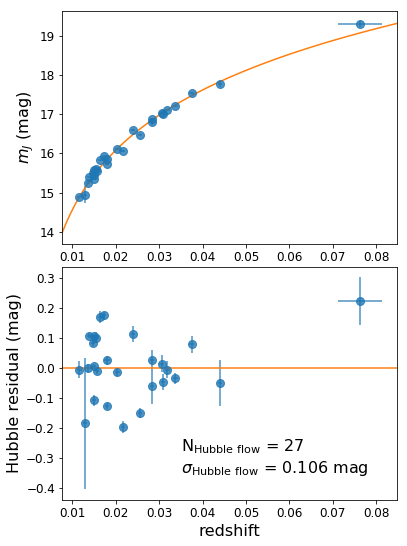

In [27]:
# plot Hubble diagram & residuals
fighflow = plt.figure(figsize=(6,9))
plt.subplot('211')
plt.errorbar(hflow_zobs,hflow_data,yerr=hflow_ptunc,xerr=hflow_totzerr,marker='o',linestyle='none',ms=8.,alpha=0.8)
plt.ylabel(r"$m_J$ (mag)",fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
zlim = plt.xlim()
zz = np.arange(zlim[0],zlim[1]+0.002,0.001)
plt.plot(zz,distmod70(zz,mode=distmode)+hflow_wtmeanM)
plt.xlim(zlim)
plt.subplots_adjust(hspace=0.1)

plt.subplot('212')
plt.errorbar(hflow_zobs,hr,yerr=hflow_ptunc,xerr=hflow_totzerr,marker='o',linestyle='none',ms=8.,alpha=0.8)
plt.xlabel(r"redshift",fontsize=16)
plt.ylabel(r"Hubble residual (mag)",fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.plot(zlim,[0,0])
plt.xlim(zlim)
plt.text(0.035,-0.28,r"N$_\mathrm{Hubble\ flow}$ = " + "{:d}".format(nhflow),fontsize=16)
plt.text(0.035,-0.35,r"$\sigma_\mathrm{Hubble\ flow}$ = " + "{:.3f} mag".format(sighr),fontsize=16)
plt.savefig(output_figure,bbox_inches="tight")
plt.show()